## Hilfs-Funktionen 

In [2]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 

db = "chinook.db"

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)    
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)    
    
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables() 

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Empfehlungen von Alben zum Verkauf

In [5]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.*
    FROM invoice_line il
    INNER JOIN invoice i USING(invoice_id)
    INNER JOIN customer c USING(customer_id)
    WHERE c.country = "USA"
   )
   
SELECT
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS FLOAT)/ (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t USING(track_id)
INNER JOIN genre g USING(genre_id)
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


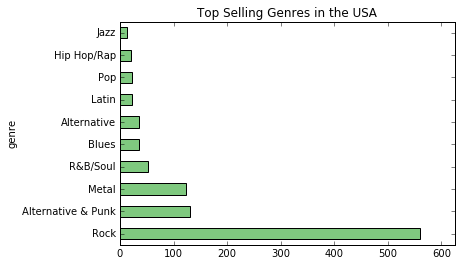

In [9]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", drop=True, inplace=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.show()

Aus den vorgeschlagenen Alben sollten diese Alben verkauft werden:
      - Red Tone(Punk)
      - Meteor and the Girls(Pop) 
      - Slim Jim Bites(Blues)

## Analyse der Mitarbeiter Verkaufsleistung

In [10]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS 
    (
     SELECT 
        c.customer_id,
        c.support_rep_id,
        SUM(i.total) Total
     FROM invoice i
     INNER JOIN customer c USING(customer_id)
     GROUP BY 1,2
    )
    
SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) Total_Sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1
'''
run_query(employee_sales_performance)

,employee,hire_date,Total_Sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


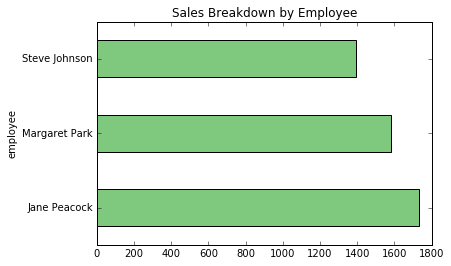

In [13]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index("employee", drop=True, inplace=True)

employee_sales["Total_Sales"].plot.barh(
    title="Sales Breakdown by Employee",
    colormap=plt.cm.Accent
)

plt.show()

Jane Peacock hat bis jetzt am meisten verkauft, ist aber auch schon am längsten im Unternehmen.

## Analyse der Verkäufe nach Ländern

In [14]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


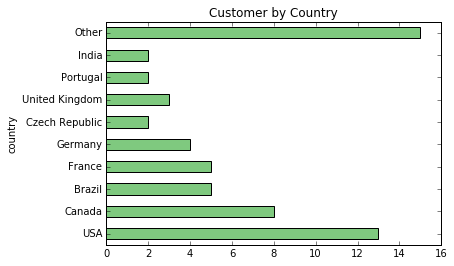

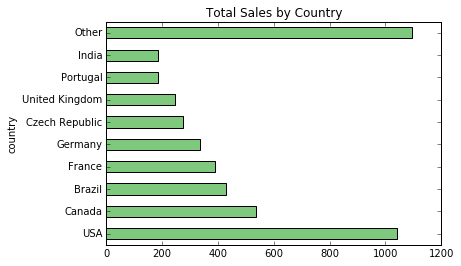

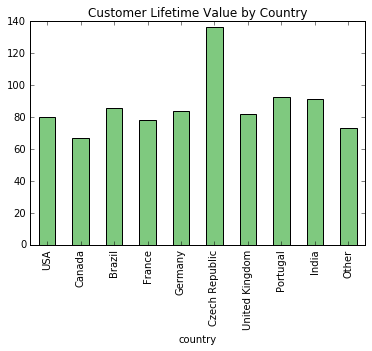

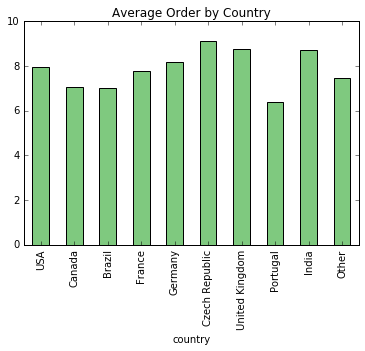

In [20]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)

country_metrics["customers"].plot.barh(
    title="Customer by Country",
    colormap=plt.cm.Accent
)
plt.show()

country_metrics["total_sales"].plot.barh(
    title="Total Sales by Country",
    colormap=plt.cm.Accent
)
plt.show()

country_metrics["customer_lifetime_value"].plot.bar(
    title="Customer Lifetime Value by Country",
    colormap=plt.cm.Accent
)
plt.show()

country_metrics["average_order"].plot.bar(
    title="Average Order by Country",
    colormap=plt.cm.Accent
)
plt.show()

## Alben vs einzelne Tracks

In [21]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
